# SV model with variational particle filter

In [2]:
import matplotlib.pyplot as plt
import torch

import ptvi

In [3]:
data_seed, algo_seed = 123, 123
T = 200

In [4]:
model = ptvi.FilteredStochasticVolatilityModelFixedParams(
    input_length=T, num_particles=30, resample=True)
model

Stochastic volatility model:
	x_t = exp(a * z_t/2) ε_t      t=1, …, 200
	z_t = b + c * z_{t-1} + ν_t,  t=2, …, 200
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Particle filter with 30 particles, AR(1) proposal:
	z_t = d + e * z_{t-1} + η_t,  t=2, …, 200
	z_1 = d + 1/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [5]:
torch.manual_seed(data_seed)
y, z_true = model.simulate()

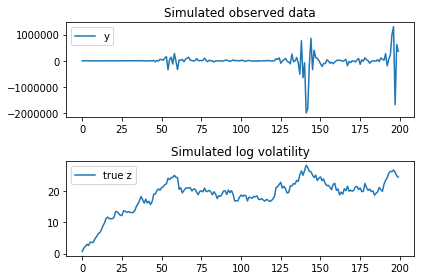

In [6]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [7]:
torch.manual_seed(algo_seed)
fit = ptvi.stoch_opt(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BFGS: Particle filtered stochastic volatility model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


AttributeError: module 'torch' has no attribute 'logsumexp'

In [ ]:
fit.plot_losses()

In [ ]:
fit.summary(true=params)

In [ ]:
!pip freeze